In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

# display options
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv('../no_dupe_tracks.csv')

print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (23450, 72)


,track_id,track_name,track_artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,label_r&b_neo soul,label_r&b_urban contemporary,label_r&b_hip pop,label_r&b_new jack swing,label_latin_latin hip hop,label_latin_reggaeton,label_latin_tropical,label_latin_latin pop,label_edm_progressive electro house,label_edm_electro house,label_edm_big room,label_edm_pop edm,label_pop_indie poptimism,label_pop_post-teen pop,label_pop_dance pop,label_pop_electropop,label_rock_album rock,label_rock_classic rock,label_rock_permanent wave,label_rock_hard rock,label_rap_trap,label_rap_hip hop,label_rap_southern hip hop,label_rap_gangster rap,key_11,key_7,key_8,key_9,key_3,key_6,key_1,key_4,key_5,key_2,key_0,key_10,mode_1,mode_0,energy_dance,tempo_energy,acoustic_instrument,valence_energy,duration_min,loudness_per_min,log_duration,log_loudness,log_instrumentalness,energy_loudness_ratio,valence_minus_energy,dance_tempo_ratio,acoustic_instrument_ratio,speech_to_instrument_ratio,energy_squared,tempo_squared,valence_squared,danceability_squared,dance_energy_tempo,valence_energy_loudness,acoustic_speech_live
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,0.642049,1.201614,1.367123,-0.481362,-0.333898,-0.377953,-0.809230,0.031908,0.042927,-0.518874,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1.577694,0.868910,-0.180468,0.561323,-0.518874,0.446803,-0.443127,1.834871,-0.393283,1.215489,-0.770012,0.221158,0.165544,0.050689,1.350841,-0.063729,-0.191017,0.603834,1.392655,-0.700445,-0.322506
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,0.490412,0.643317,0.585766,-0.688642,-0.468670,-0.359177,1.081061,0.782522,-0.777198,-1.056268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.936301,-0.120922,-0.176680,1.016251,-1.056268,0.035237,-1.140271,0.503982,-0.368007,0.152567,0.242285,0.834571,-0.500757,-0.552856,0.608778,-0.768004,0.675748,0.425218,0.204230,0.386671,-0.263970
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,0.138889,1.284529,1.100090,-0.324422,-0.436799,-0.377849,-0.519562,0.439384,0.116227,-0.822017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.188356,0.988655,-0.180445,1.046013,-0.822017,0.304084,-0.820820,1.302465,-0.393143,0.773009,-0.476592,-0.150423,-0.479521,-0.521332,1.468434,0.006032,0.248429,0.031660,1.116450,-0.205410,-0.296098
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,0.435271,1.279002,0.984309,-0.050024,-0.667642,-0.377911,0.089582,-1.001795,0.039953,-0.947750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.458113,0.922279,-0.180464,-0.531216,-0.947750,0.233759,-0.988994,1.100863,-0.393226,0.627762,-1.705286,0.090119,-0.482891,-0.451691,1.460535,-0.066535,-0.974633,0.361589,1.286735,-0.893578,-0.301270
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,-0.033426,0.742815,0.685151,-0.702460,-0.432701,-0.377953,-0.692585,0.919777,0.115037,-0.614172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.591583,0.590883,-0.180468,1.213371,-0.614172,0.176499,-0.557932,0.640861,-0.393283,0.235170,0.293633,-0.258868,0.023768,-0.181240,0.734685,0.004891,0.861334,-0.150795,0.591633,0.397196,-0.337570


In [3]:
features = df.drop(columns=[col for col in df.columns if col.startswith('label_')])
features = features.drop(columns=['track_id', 'track_name', 'track_artist'])

labels_main_only = (
    df[[col for col in df.columns if col.startswith('label_')]]
    .idxmax(axis=1)
    .apply(lambda x: x.replace('label_', '').split('_')[0])
)

labels_main_and_sub = (
    df[[col for col in df.columns if col.startswith('label_')]]
    .idxmax(axis=1)
    .apply(lambda x: x.replace('label_', ''))
)


In [4]:
main_genre_encoder = LabelEncoder()
main_encoded = main_genre_encoder.fit_transform(labels_main_only)

sub_genre_encoder = LabelEncoder()
sub_encoded = sub_genre_encoder.fit_transform(labels_main_and_sub)

X = features.copy()

X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(
    X, main_encoded, test_size=0.2, random_state=42, stratify=main_encoded)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X, sub_encoded, test_size=0.2, random_state=42, stratify=sub_encoded)


In [5]:
# light param_dist for garbage computer...
fast_param_dist = {
    "n_estimators":     [400],
    "max_depth":        [2, 8],
    "learning_rate":    [0.15],
    "subsample":        [0.8],
    "colsample_bytree": [0.8],
}


In [6]:
from xgboost import QuantileDMatrix


def train_and_evaluate(X_train, X_test, y_train, y_test, label_encoder, model_name,
                       n_iter=20, cv=3, random_state=42):
    """Train an XGBClassifier with RandomizedSearchCV and evaluate on the test set."""

    dtrain = QuantileDMatrix(X_train, y_train)           # GPU-friendly
    dtest = QuantileDMatrix(X_test,   y_test, ref=dtrain) # share quantiles

    base_model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        device          = "cuda",        # GPU
        tree_method     = "hist",        # fastest for both CPU & GPU
        grow_policy     = "depthwise",
        nthread=1,              # EXPERIMENTAL, FROM -1
    )

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=fast_param_dist,
        n_iter=4,           # only 4 combinations
        cv=3,
        scoring="accuracy",
        n_jobs=1,   #EXPERIMENTAL, FROM -1
        random_state=42,
        verbose=1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # booster = best_model.get_booster()
    # booster.set_param({"device":"cuda"})
    # shap_vals = booster.predict(dtrain, pred_contribs=True)

    # Evaluation
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n===== {model_name} Tuned Classification Report =====")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print(f"Overall Accuracy: {acc:.4f}")

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title(f"{model_name} – Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    #output what the best model is
    print(f"Best model parameters: {search.best_params_}")

    return best_model #, shap_vals


D:\School\Fourth_Semester\ML\fixed_final_project\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


D:\School\Fourth_Semester\ML\fixed_final_project\venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [16:31:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



===== Main Genre (XGBoost) Tuned Classification Report =====
              precision    recall  f1-score   support

         edm       0.68      0.69      0.68       763
       latin       0.47      0.34      0.39       684
         pop       0.42      0.46      0.44       914
         r&b       0.47      0.37      0.41       680
         rap       0.60      0.70      0.65       976
        rock       0.62      0.68      0.65       673

    accuracy                           0.55      4690
   macro avg       0.54      0.54      0.54      4690
weighted avg       0.54      0.55      0.54      4690

Overall Accuracy: 0.5495


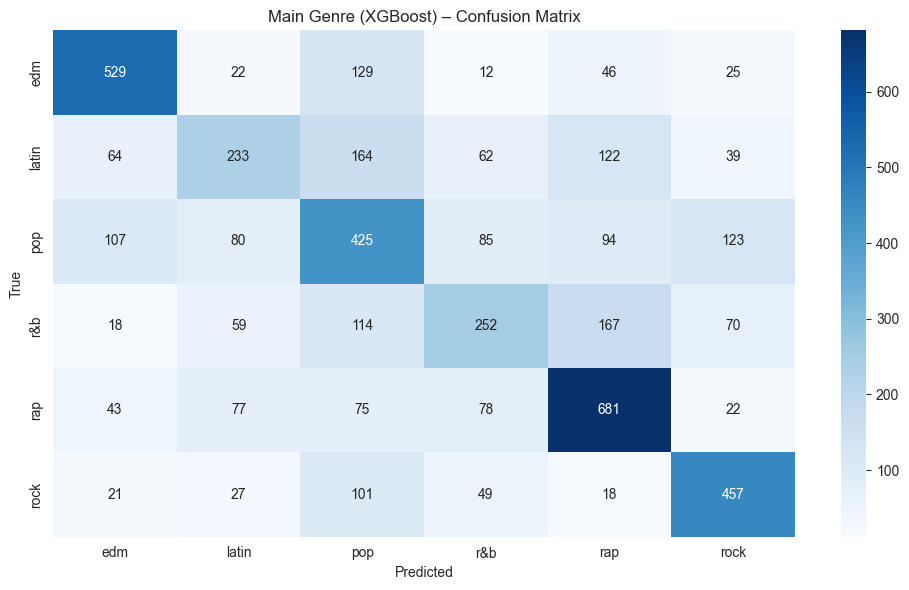

Best model parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.15, 'colsample_bytree': 0.8}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


D:\School\Fourth_Semester\ML\fixed_final_project\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



===== Main + Subgenre (XGBoost) Tuned Classification Report =====
                               precision    recall  f1-score   support

                 edm_big room       0.38      0.41      0.39       157
            edm_electro house       0.37      0.43      0.40       225
                  edm_pop edm       0.21      0.08      0.12       146
edm_progressive electro house       0.32      0.39      0.35       236
          latin_latin hip hop       0.23      0.14      0.17       187
              latin_latin pop       0.24      0.27      0.25       196
              latin_reggaeton       0.31      0.35      0.32       107
               latin_tropical       0.22      0.18      0.19       193
                pop_dance pop       0.21      0.26      0.23       248
               pop_electropop       0.16      0.10      0.12       215
          pop_indie poptimism       0.23      0.29      0.26       265
            pop_post-teen pop       0.19      0.17      0.18       187
         

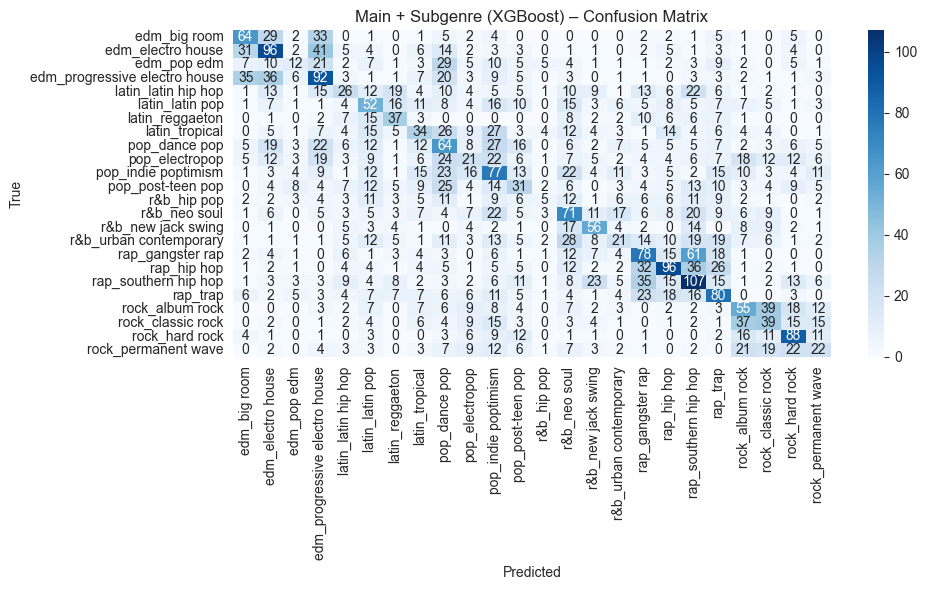

Best model parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 2, 'learning_rate': 0.15, 'colsample_bytree': 0.8}


In [7]:
model_main = train_and_evaluate(
    X_train_main, X_test_main, y_train_main, y_test_main,
    main_genre_encoder, "Main Genre (XGBoost)"
)

model_sub = train_and_evaluate(
    X_train_sub, X_test_sub, y_train_sub, y_test_sub,
    sub_genre_encoder, "Main + Subgenre (XGBoost)"
)


In [8]:
# joblib.dump(model_main, 'xgboost_main_genre.pkl')
# joblib.dump(model_sub, 'xgboost_main_and_sub.pkl')
